In [21]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


# Data introduction and initial data preparation

Our dataset encompasses match outcomes for every La Liga game from the 1995-1996 season to the 2023-2024 season, up to Matchday 8, and it also includes half-time scores.
Columns:
- Season 
- HomeTeam 
- AwayTeam
- FTHG (Full-time home goals)
- FTAG (Full-time away goals)
- FTR (Full-time result)
- HTHG (Half-time home goals)
- HTAG (Half-time away goals)
- HTR (Half-time result).

Our objective is to predict the outcome of the matches using only pre-game information. This is a multi-class classification problem with three classes: Home team wins, draw or home team loses

In [22]:
df = pd.read_csv('/Users/evaristovillasecoarribas/Desktop/Data-Science/DS_projects/football-predictor/LaLiga_Matches.csv')
df.sample(4)

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR
7376,2013-14,17-05-2014,Real Madrid,Espanol,3,1,H,0.0,0.0,D
6431,2011-12,22-01-2012,Real Madrid,Ath Bilbao,4,1,H,1.0,1.0,D
10237,2021-22,08-01-2022,Granada,Barcelona,1,1,D,0.0,0.0,D
4569,2006-07,18-02-2007,Osasuna,Celta,0,1,A,0.0,1.0,A


In [23]:
type(df['Season'].iloc[0])

str

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10883 entries, 0 to 10882
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Season    10883 non-null  object 
 1   Date      10883 non-null  object 
 2   HomeTeam  10883 non-null  object 
 3   AwayTeam  10883 non-null  object 
 4   FTHG      10883 non-null  int64  
 5   FTAG      10883 non-null  int64  
 6   FTR       10883 non-null  object 
 7   HTHG      10881 non-null  float64
 8   HTAG      10881 non-null  float64
 9   HTR       10881 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 850.4+ KB


We will drop the columns that have half-time information

In [25]:
df[(df['Season']=='2023-24') & (df['HomeTeam']=='Vallecano')]

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR
10833,2023-24,28-08-2023,Vallecano,Ath Madrid,0,7,A,0.0,3.0,A
10843,2023-24,15-09-2023,Vallecano,Alaves,2,0,H,1.0,0.0,H
10859,2023-24,24-09-2023,Vallecano,Villarreal,1,1,D,1.0,1.0,D
10875,2023-24,30-09-2023,Vallecano,Mallorca,2,2,D,1.0,1.0,D


In [26]:
df.drop(columns=['HTHG','HTAG','HTR'],inplace=True)
df.dropna(inplace=True)

We will limit our data to the teams that have at least 200 matches played in the first division across all seasons.

In [27]:
teams = df['HomeTeam'].value_counts()[lambda x: x>200].index.to_list()

df= df[df['HomeTeam'].isin(teams) & df['AwayTeam'].isin(teams)]

print(teams)

['Barcelona', 'Ath Bilbao', 'Valencia', 'Real Madrid', 'Espanol', 'Ath Madrid', 'Sociedad', 'Sevilla', 'Betis', 'Celta', 'Villarreal', 'La Coruna', 'Osasuna', 'Mallorca', 'Getafe', 'Valladolid', 'Malaga', 'Santander', 'Zaragoza', 'Vallecano', 'Levante', 'Alaves']


We will encode the categorical variables: teams, season and result with integers by defining some maps.

In [28]:
teams_map = {team:i for i, team in enumerate(teams)}
seasons_map = {value: i+1 for i, (value, _) in enumerate(df.groupby('Season'))}
results_map = {'H': 2, 'D': 0, 'A': 1}

df['HomeTeam']=df['HomeTeam'].map(teams_map)
df['AwayTeam']=df['AwayTeam'].map(teams_map)
df['Season'] = df['Season'].map(seasons_map)
df['Result'] = df['FTR'].map({'H': 2, 'D': 0, 'A': 1})

We define a variable encoding the goal difference of each match

In [29]:
df['Goaldiff'] = df['FTHG']-df['FTAG']

In [30]:
df.sample(4)

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Result,Goaldiff
3752,10,22-12-2004,2,4,3,0,H,2,3
257,1,28-01-1996,8,19,0,0,D,0,0
4002,11,21-09-2005,18,12,3,1,H,2,2
7463,20,20-10-2014,6,14,1,2,A,1,-1


### Create dictionary of dataframes for each sesason

In [31]:
teams = df['HomeTeam'].unique()
seasons = df['Season'].unique()

seasons_dict = {value: group for value, group in df.groupby('Season')}

Potential features to consider in our model:
- Teams that play
- Season stats: positions in the league of home and away teams prior to that game, cumulative goal difference
- Home and away performance metrics 
- Previous seasons stats between teams 

### Function to return the position in the league of each team prior to the game. Also the cumulative goaldifference on that season prior to each game

In [32]:
def calculate_league_position(data):

    # dictionary that stores the points info about the team
    tracker = {}
    home_team_positions = []
    away_team_positions = []
    home_team_points = []
    away_team_points = []
    home_cum_goal_diff = []
    away_cum_goal_diff = []

    # get list of teams 
    teams = set(data['HomeTeam'].unique()) 

    # dicitonary that will store points and goal differences for ranking of teams
    tracker = {team: {'points': 0, 'home_points': 0, 'away_points': 0, 'goal_diff': 0} for team in teams} 

    for __, row in data.iterrows():

        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goal_diff = row['Goaldiff']
        result = row['Result']

        # Keep track of goal differences
        home_cum_goal_diff.append(tracker[home_team]['goal_diff'])
        away_cum_goal_diff.append(tracker[away_team]['goal_diff'])

        # Keep track of home and away points
        home_team_points.append(tracker[home_team]['home_points'])
        away_team_points.append(tracker[away_team]['away_points'])

        # Update goal diff
        tracker[home_team]['goal_diff'] += home_goal_diff
        tracker[away_team]['goal_diff'] -= home_goal_diff

        # Update points based on match result
        if result == 2:
            tracker[home_team]['points'] += 3
            tracker[home_team]['home_points'] += 3
        elif result == 1:
            tracker[away_team]['points'] += 3
            tracker[away_team]['away_points'] += 3
        else:  # Draw
            tracker[home_team]['points'] += 1
            tracker[away_team]['points'] += 1
            tracker[home_team]['home_points'] +=1
            tracker[away_team]['away_points'] +=1

        # rank the teams
        sorted_teams = sorted(tracker.items(), key=lambda x: (x[1]['points'], x[1]['goal_diff']), reverse=True)
        positions = {team[0]: idx+1 for idx, team in enumerate(sorted_teams)}

        home_team_positions.append(positions[home_team])
        away_team_positions.append(positions[away_team])


    # Add the positions as columns to the dataframe
    data['home_team_position'] = home_team_positions
    data['away_team_position'] = away_team_positions
    data['pos_dif'] = data['home_team_position'] - data['away_team_position'] 
    data['home_cum_gd'] = home_cum_goal_diff
    data['away_cum_gd'] = away_cum_goal_diff
    data['home_points'] = home_team_points
    data['away_points'] = away_team_points

    return data

In [33]:
seasons_with_positions = {season: calculate_league_position(group) for season, group in seasons_dict.items()}

In [34]:
seasons_with_positions[1].head(30)

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Result,Goaldiff,home_team_position,away_team_position,pos_dif,home_cum_gd,away_cum_gd,home_points,away_points
0,1,02-09-1995,11,2,3,0,H,2,3,1,15,-14,0,0,0,0
2,1,03-09-1995,1,17,4,0,H,2,4,1,15,-14,0,0,0,0
3,1,03-09-1995,5,6,4,1,H,2,3,2,14,-12,0,0,0,0
8,1,03-09-1995,15,0,0,2,A,1,-2,12,4,8,0,0,0,0
9,1,03-09-1995,19,3,1,5,A,1,-4,15,2,13,0,0,0,0
13,1,09-09-1995,8,18,3,1,H,2,2,6,11,-5,0,0,0,0
14,1,09-09-1995,3,1,1,2,A,1,-1,2,1,1,4,4,0,0
18,1,10-09-1995,17,5,0,4,A,1,-4,15,1,14,-4,3,0,0
21,1,10-09-1995,2,15,1,0,H,2,1,7,13,-6,-3,-2,0,0
22,1,16-09-1995,1,5,0,2,A,1,-2,2,1,1,5,7,3,3


Relevant features to consider potentially in the model:
- Half-time goal diference
- Who plays home vs away
- Teams
- Position diference in the league of the teams

Target variable: full time result 

In [35]:
target = 'Result'
features = ['HomeTeam','AwayTeam','pos_dif','home_cum_gd','away_cum_gd','home_points','away_points']

### EDA

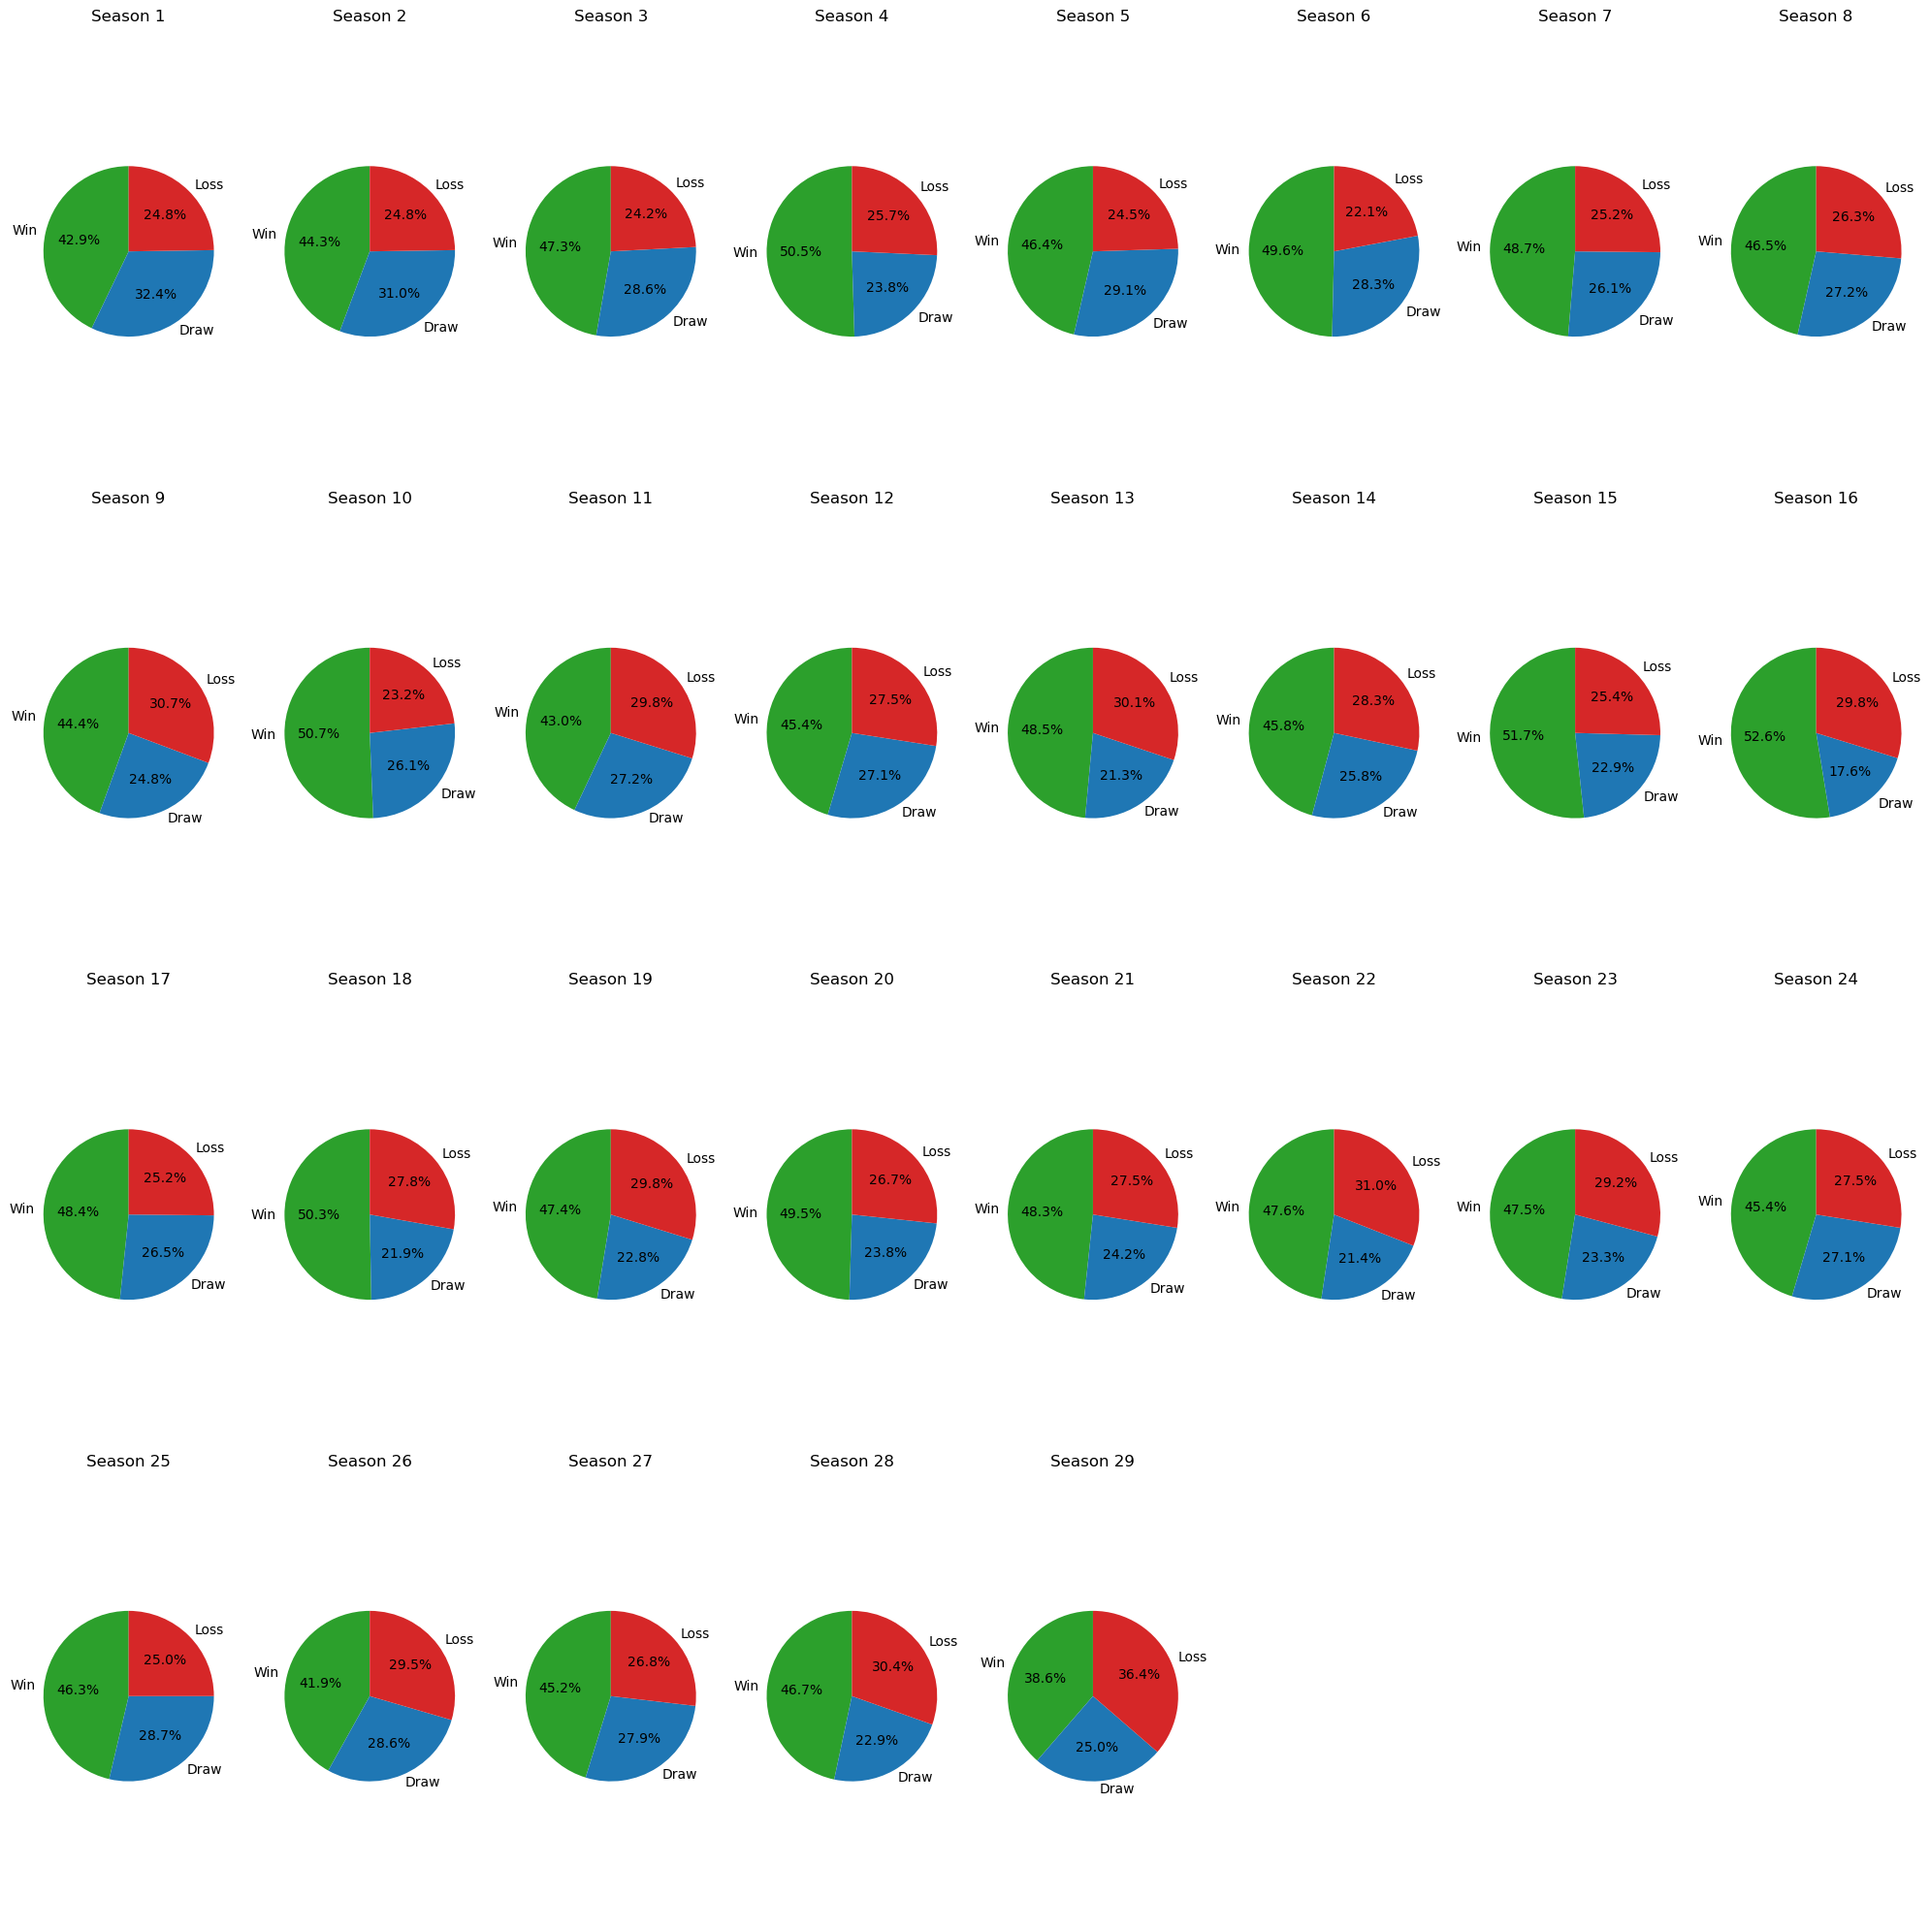

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# Create a DataFrame from value counts directly
dfa = pd.DataFrame([df['Result'].value_counts() for df in seasons_dict.values()], index=seasons).reset_index(names="Season")

n_col = 8

# calculate number of rows
num_rows = math.ceil(len(seasons) / n_col)

# Plotting pie charts for each season with smaller size
fig, axes = plt.subplots(num_rows, n_col, figsize=(20, 5 * num_rows))  # Adjusted figsize for 8 plots per row

# Flatten axes array for easy indexing if there are multiple rows
axes = axes.flatten()

for i, season in enumerate(seasons):
    ax = axes[i]
    # Get the counts for the current season
    counts = dfa.loc[dfa['Season'] == season].drop(columns='Season').values.flatten()
    labels = ['Win', 'Draw', 'Loss']
    
    # Plot pie chart with a smaller radius
    ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=["#2ca02c", "#1f77b4", "#d62728"])
    
    # Reduce space between title and pie even further (smaller padding)
    ax.set_title(f"Season {season}", pad=3)  # Further reduced padding for title spacing
    ax.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle

# Hide any unused subplots if the number of seasons is less than a multiple of 8
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to minimize gaps between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.1)  # Even tighter spacing between subplots
plt.tight_layout(pad=1)  # Further reduce padding around the plot

# Show the plot
plt.show()



### Train test split
We will need to make a stratified train-test split to fix class imbalance but also the split should repsect the time ordering of the seasons. 

We will try three models:
- Logisitic regression (Baseline).
- XGBoost with SMOTE: To handle the class imbalance with XGBOOST we will use SMOTE (Synthetic Minority Over Sampling Technique) which essentially creates synthetic samples of the minority classes by interpolation. 
- Random forests with class weighting: For random forests we use class weighting which effectively increases the weights of the minority classes so that misclassification of the minority classes is penalized.

Last season will be saved for testing purposes

In [37]:
X_test = seasons_with_positions[seasons[-1]][features]
y_test = seasons_with_positions[seasons[-1]][target]

# Remove last season from a combined dataframe with training data (all seasons but last one)
del seasons_with_positions[seasons[-1]]
combined_df = pd.concat(seasons_with_positions.values(), ignore_index=True)

In [38]:
X_train = combined_df[features]
y_train = combined_df[target]

# Model training

### Logistic regression

Training Error: 0.4120119305856833
Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.67      0.18      0.29        11
           1       0.74      0.88      0.80        16
           2       0.68      0.88      0.77        17

    accuracy                           0.70        44
   macro avg       0.70      0.65      0.62        44
weighted avg       0.70      0.70      0.66        44



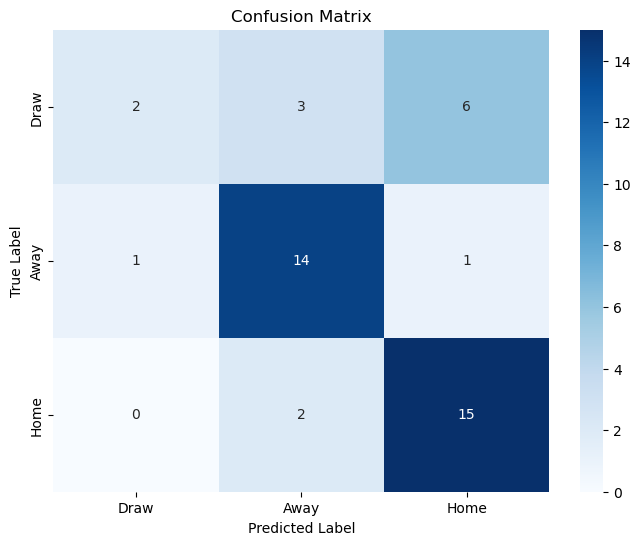

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

log_reg = LogisticRegression(max_iter=200)

## fit the model
log_reg.fit(X_train,y_train)

y_train_pred = log_reg.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = 1 - train_accuracy

# Print the training error
print(f"Training Error Rate: {train_error}")

y_pred = log_reg.predict(X_test)
print("Classification Report for Best Model:")
print(classification_report(y_test, y_pred))

label_mapping = {2: "Home", 0: "Draw", 1: "Away"}
cm = confusion_matrix(y_test, y_pred)
labels = [label_mapping[i] for i in sorted(label_mapping.keys())]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### XGBoost with SMOTE

In [42]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


model = xgb.XGBClassifier(objective='multi:softmax', num_class=3)
smote = SMOTE(random_state=42)

pipeline = Pipeline([
    ('smote', smote),  # Apply SMOTE to the training data
    ('classifier', model)  # XGBoost classifier
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

param_grid = {
    'classifier__n_estimators': range(100,200),
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [1.0]
}

# Set up TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Set up GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=0)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
print("Best parameters found: ", grid_search.best_params_)

# Predict with the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
print("Classification Report for Best Model:")
print(classification_report(y_test, y_pred_best))


Best parameters found:  {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__n_estimators': 101, 'classifier__subsample': 0.8}
Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.31      0.45      0.37        11
           1       0.80      0.75      0.77        16
           2       0.77      0.59      0.67        17

    accuracy                           0.61        44
   macro avg       0.63      0.60      0.60        44
weighted avg       0.67      0.61      0.63        44



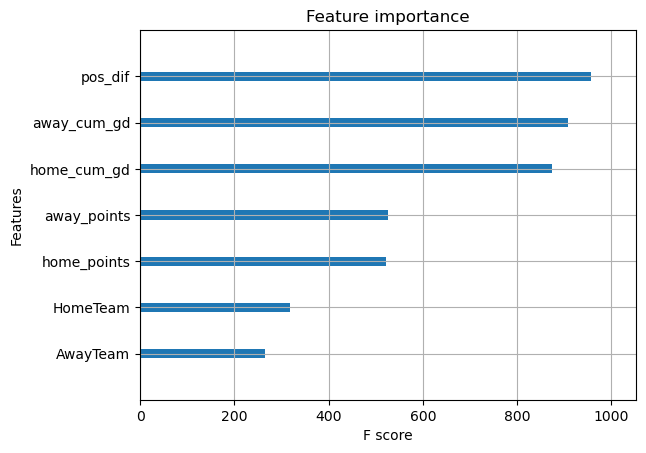

HomeTeam: 11.741402562373567 %
AwayTeam: 11.935266351989211 %
pos_dif: 13.250168577208363 %
home_cum_gd: 17.76803776129467 %
away_cum_gd: 17.79332434254889 %
home_points: 14.177343223196223 %
away_points: 13.334457181389075 %


In [43]:
import matplotlib.pyplot as plt
from xgboost import plot_importance 

plot_importance(best_model[1], importance_type='weight', show_values=False)
plt.show()

importances = model.get_booster().get_score(importance_type='weight')
total_importance = sum(importances.values())

for key, value in importances.items():
    print(f'{key}: {value/total_importance*100} %')

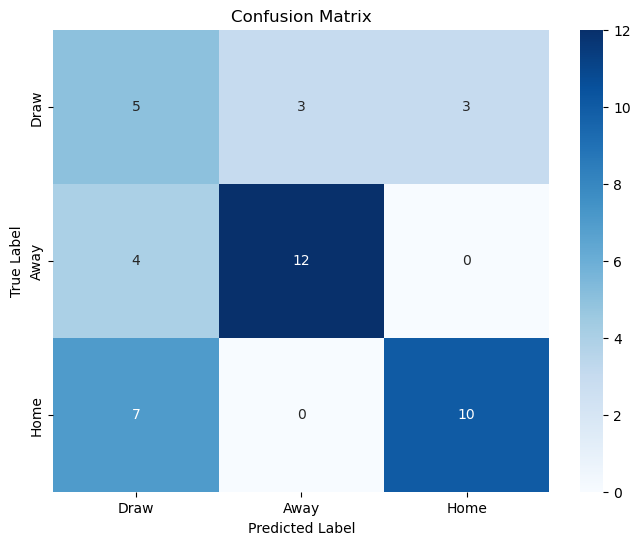

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score

label_mapping = {2: "Home", 0: "Draw", 1: "Away"}
cm = confusion_matrix(y_test, y_pred_best)
labels = [label_mapping[i] for i in sorted(label_mapping.keys())]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Random forest with class weighting

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


params = {
    'class_weight': ['balanced'],
    'n_estimators': range(50,200),     # Number of trees
    'max_depth': range(2,6),         # Maximum depth of trees
    'criterion': ['gini','entropy']     # Splitting criterion ('gini' or 'entropy')
}

model_rf = RandomForestClassifier(**params)

# Set up TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Set up GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv=tscv, n_jobs=-1, verbose=0)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
print("Best parameters found: ", grid_search.best_params_)

# Predict with the best model
best_model_rf = grid_search.best_estimator_
y_pred_best_rf = best_model_rf.predict(X_test)

# Evaluate the best model
print("Classification Report for Best Model:")
print(classification_report(y_test, y_pred_best_rf))

Best parameters found:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 111}
Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.62      0.45      0.53        11
           1       0.75      0.94      0.83        16
           2       0.81      0.76      0.79        17

    accuracy                           0.75        44
   macro avg       0.73      0.72      0.72        44
weighted avg       0.74      0.75      0.74        44



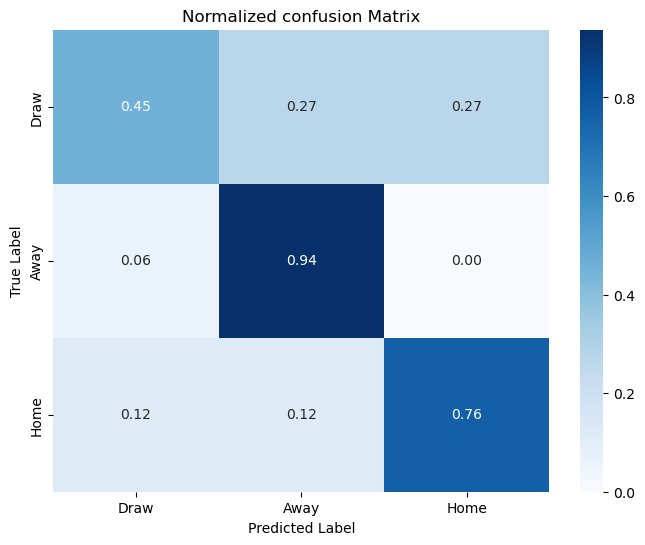

In [64]:
label_mapping = {2: "Home", 0: "Draw", 1: "Away"}
cm = confusion_matrix(y_test, y_pred_best_rf)
cm_normalized = cm/cm.sum(axis=1,keepdims=True)
labels = [label_mapping[i] for i in sorted(label_mapping.keys())]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized confusion Matrix')
plt.show()

In [68]:
from sklearn.metrics import log_loss

predicted_probs = best_model_rf.predict_proba(X_test)
predicted_probs = predicted_probs / np.sum(predicted_probs, axis=1, keepdims=True)


log_loss_value = log_loss(y_test, predicted_probs)
print(f'Log Loss: {log_loss_value}')

Log Loss: 0.8203579860825984


As we can observe the classifier predicts away and home accurately. However there are some misclassifications of the draws. The false positive rate for draws is 0.55: 25 % of the away instances are incorrectly classified as draws and 35% of the home instances. The false negative rate for draws is 0.54: 27% of draws are misclassified as away and 27% as home.

Conclusions:
Logistic Regression and Random Forests both perform similarly in terms of accuracy (70%), but Random Forests generally have a better balance across the "Home" and "Away" classes. XGBoost, despite having a good performance for "Away" and "Home," performs poorly for "Draw," which results in a significantly lower F1-score and overall performance. We can observe that overall Random Forests seems to be the most well-rounded model across all classes (with decent precision, recall, and F1-score for all three categories).

### Comparative Analysis: Model Performance and Betting Odds

We will compare the performance of our Random Forest model with the implied probabilites derived from betting odds obtained from https://www.oddsportal.com/. Implied probabilities are calculated based on the odds provided by bookmakers, reflecting their expectations of outcomes. We will compare the Log Losses.

In [ ]:
# This function computes the implied probabilities from the odds (American system)
def implied_priob(odds):
    if odds<0:
        prob = abs(odds)/(abs(odds)+100)
    else:
        prob = 100 / (odds+100)
    return prob

Load the dataframe of odds

In [69]:
df_odds = pd.read_csv('/Users/evaristovillasecoarribas/Desktop/laligamerged.csv')
df_odds['team1'].unique()
df_odds

,date,team1,team2,1,X,2
0,2024-05-26,Sevilla,Barcelona,338,320,-141
1,2024-05-26,Celta Vigo,Valencia,-109,261,287
2,2024-05-26,Las Palmas,Alaves,133,246,200
3,2024-05-26,Getafe,Mallorca,129,220,229
4,2024-05-25,Real Madrid,Betis,-435,599,1002
...,...,...,...,...,...,...
374,2023-08-12,Ath Bilbao,Real Madrid,223,240,121
375,2023-08-12,Las Palmas,Mallorca,154,187,219
376,2023-08-12,Real Sociedad,Girona,-130,257,372
377,2023-08-11,Sevilla,Valencia,-109,235,322


Reaname some rows so the team names match with the original dataframe

In [70]:
df_odds[['team1','team2']]=df_odds[['team1','team2']].replace('Celta Vigo','Celta')
df_odds[['team1','team2']]=df_odds[['team1','team2']].replace('Atl. Madrid','Ath Madrid')
df_odds[['team1','team2']]=df_odds[['team1','team2']].replace('Real Sociedad','Sociedad')

In [71]:
df_odds['HomeTeam']=df_odds['team1'].map(teams_map)
df_odds['AwayTeam']=df_odds['team2'].map(teams_map)
df_odds.dropna(inplace=True)

In [97]:
df_odds['HomeProb']=df_odds['1'].apply(implied_priob)
df_odds['DrawProb']=df_odds['X'].apply(implied_priob)
df_odds['AwayProb']=df_odds['2'].apply(implied_priob)
df_odds['date']=pd.to_datetime(df_odds['date'])
df_odds = df_odds.rename(columns={'date' : 'Date'})

In [94]:
last_season_df = df[df['Season']==29]
last_season_df['Date']=pd.to_datetime(last_season_df['Date'], format='%d-%m-%Y')

/var/folders/40/6z6fw5_s1977zvkchq47yn280000gn/T/ipykernel_40212/797638417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_season_df['Date']=pd.to_datetime(last_season_df['Date'], format='%d-%m-%Y')


Merge odds and result dataframes

In [114]:
df_merged = df_odds.merge(last_season_df, on='Date', how='inner')

In [103]:
df_merged

,Date,team1,team2,1,X,2,HomeTeam_x,AwayTeam_x,HomeProb,DrawProb,AwayProb,Season,HomeTeam_y,AwayTeam_y,FTHG,FTAG,FTR,Result,Goaldiff
0,2023-10-01,Betis,Valencia,108,225,285,8.0,2.0,0.480769,0.307692,0.259740,29,21,12,0,2,A,1,-2
1,2023-10-01,Betis,Valencia,108,225,285,8.0,2.0,0.480769,0.307692,0.259740,29,8,2,3,0,H,2,3
2,2023-09-30,Alaves,Osasuna,150,202,213,21.0,12.0,0.400000,0.331126,0.319489,29,14,10,0,0,D,0,0
3,2023-09-30,Alaves,Osasuna,150,202,213,21.0,12.0,0.400000,0.331126,0.319489,29,19,13,2,2,D,0,0
4,2023-09-30,Alaves,Osasuna,150,202,213,21.0,12.0,0.400000,0.331126,0.319489,29,6,1,3,0,H,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,2023-08-13,Celta,Osasuna,110,217,281,9.0,12.0,0.476190,0.315457,0.262467,29,9,12,0,2,A,1,-2
79,2023-08-13,Celta,Osasuna,110,217,281,9.0,12.0,0.476190,0.315457,0.262467,29,10,8,1,2,A,1,-1
80,2023-08-13,Celta,Osasuna,110,217,281,9.0,12.0,0.476190,0.315457,0.262467,29,14,0,0,0,D,0,0
81,2023-08-12,Ath Bilbao,Real Madrid,223,240,121,1.0,3.0,0.309598,0.294118,0.452489,29,1,3,0,2,A,1,-2


In [ ]:
# Normalize probabilities
odds_probs = np.array(df_merged[['DrawProb','AwayProb','HomeProb']])
odds_probs = odds_probs / np.sum(odds_probs, axis=1, keepdims=True)

In [110]:
log_loss_bet = log_loss(df_merged['Result'].values,odds_probs, labels=[0,1,2])

We compute the percentage improvement of the random forest model against the betting house's probablities

In [113]:
improvement_over_bet = 100*(log_loss_bet-log_loss_value)/log_loss_bet
improvement_over_bet

24.4400635769233